<a href="https://colab.research.google.com/github/MananMehta07/Fruit-Classification-using-CNN/blob/main/Fruit_Classification(MPR).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fruit Classification using CNN - Keras


With Deep Learning's capabilities, fruit classification can be well implemented as a replacement of traditional manual methods in the agricultural, horticultural and botany domains. By utilizing these models,we can introduce efficiency and accuracy into various fruit-related processes.


# 1. Introduction

Fruits are an essential part of our daily diets. In various production processes using fruits, sorting plays a crucial role, and implementation of AI systems is revolutionizing this task with highly accurate deep learning models.

### Challenge:
Identifying and grading fruits is a tough task due to their varying shapes, colors, and textures. The main challenges involve differentiating between different types of fruits and distinguishing among various varieties of the same fruit. Accurate fruit classification is vital for determining their prices in supermarkets.


# 1.1 Importing Required Libraries and Packages

In [ ]:
# Libraries for file and directory operations
import os
import shutil
import glob
import random

# avoid warnings
import warnings
warnings. filterwarnings('ignore')

# Library for data processing
import numpy as np
import math
import pandas as pd

# Libraries for data visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image

# Libraries for deep learning model
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1.2 Importing & Loading the Fruits360 Dataset

In [ ]:
data=os.getcwd()
# dataset path
dataset_path = data+'\\fruits-360_dataset\\fruits-360'

# Define training and test folders
training_folder_path = data+"\\fruits-360_dataset\\fruits-360\\Training"
test_folder_path = data+"\\fruits-360_dataset\\fruits-360\\Test"

In [ ]:
# Counting total labels
def count_labels(folder_path):
    label_count = 0
    for _, dirs, _ in os.walk(folder_path):
        label_count += len(dirs)
        break  # Only count the top-level directories and exit the loop
    return label_count

num_labels = count_labels(training_folder_path)
print(f"Number of labels (folders) in the training dataset: {num_labels}")

Number of labels (folders) in the training dataset: 131


This means that there are 131 classes of fruits and vegetable within the dataset (including variants).

### Exploring labels within training folder

In [ ]:
# Get a list of all labels (subfolder names) within the training folder
labels = [label for label in os.listdir(training_folder_path) if os.path.isdir(os.path.join(training_folder_path, label))]

# Sort the labels alphabetically
sorted_labels = sorted(labels)

# Print the list of labels
print("Sorted Labels:")
for label in sorted_labels:
    print(label)

Sorted Labels:
Apple Braeburn
Apple Crimson Snow
Apple Golden 1
Apple Golden 2
Apple Golden 3
Apple Granny Smith
Apple Pink Lady
Apple Red 1
Apple Red 2
Apple Red 3
Apple Red Delicious
Apple Red Yellow 1
Apple Red Yellow 2
Apricot
Avocado
Avocado ripe
Banana
Banana Lady Finger
Banana Red
Beetroot
Blueberry
Cactus fruit
Cantaloupe 1
Cantaloupe 2
Carambula
Cauliflower
Cherry 1
Cherry 2
Cherry Rainier
Cherry Wax Black
Cherry Wax Red
Cherry Wax Yellow
Chestnut
Clementine
Cocos
Corn
Corn Husk
Cucumber Ripe
Cucumber Ripe 2
Dates
Eggplant
Fig
Ginger Root
Granadilla
Grape Blue
Grape Pink
Grape White
Grape White 2
Grape White 3
Grape White 4
Grapefruit Pink
Grapefruit White
Guava
Hazelnut
Huckleberry
Kaki
Kiwi
Kohlrabi
Kumquats
Lemon
Lemon Meyer
Limes
Lychee
Mandarine
Mango
Mango Red
Mangostan
Maracuja
Melon Piel de Sapo
Mulberry
Nectarine
Nectarine Flat
Nut Forest
Nut Pecan
Onion Red
Onion Red Peeled
Onion White
Orange
Papaya
Passion Fruit
Peach
Peach 2
Peach Flat
Pear
Pear 2
Pear Abate
Pear F

From the above printed labels, we can see that a few fruits are available in more than one variety and have been separately labeled as belonging to a different class.

# 1.3 Sorting and filtering the dataset

The dataset contains both fruits and vegetable images as seen from the class labels. Hence, it needs to be filtered for only fruits. To achieve this, relevant folders with fruit variants need to be copied to the working directory first.

In [ ]:
# creating a folder for filtered dataset in the working directory

def create_folders(destination_path):
    # Create "filtered_dataset" folder directly
    os.makedirs(destination_path, exist_ok=True)

    # Create "training" and "test" folders within "filtered_dataset"
    training_path = os.path.join(destination_path, "training")
    test_path = os.path.join(destination_path, "test")
    os.makedirs(training_path, exist_ok=True)
    os.makedirs(test_path, exist_ok=True)

if __name__ == "__main__":
    destination_path = data+"\\fruits-360_dataset\\filtered_dataset"
    create_folders(destination_path)

    print(f"filtered_dataset folder created successfully in {destination_path}")
    print(f"Training folder created successfully in {destination_path}.")
    print(f"Test folder created successfully in {destination_path}.")

filtered_dataset folder created successfully in D:\Mihir backup\mihir\study\SEM 7\AIDS\DS Lab\MPR\Fruit classification\fruits-360_dataset\filtered_dataset
Training folder created successfully in D:\Mihir backup\mihir\study\SEM 7\AIDS\DS Lab\MPR\Fruit classification\fruits-360_dataset\filtered_dataset.
Test folder created successfully in D:\Mihir backup\mihir\study\SEM 7\AIDS\DS Lab\MPR\Fruit classification\fruits-360_dataset\filtered_dataset.


# 1.4 Classification model idea and requirements

Although a generalized model would be simpler to setup and might be able to detect different fruits, but it yet won't perform well for identifying the fruit variants.
Hence, for the model to be able to distinguish between multiple varieties of the same fruit, we will require a deeper model and a more complex model.

### Creating a subset of the main dataset with fruit labels

For this model, we will copy the following 11 fruits classes with all variant folders to both training and test datasets.
1. Apple
2. Banana
3. Cherry
4. Guava
5. Grape
6. Lychee
7. Pineapple
8. Rambutan
9. Raspberry
10. Redcurrant
11. Salak

In [ ]:
def copy_selected_folders(source_path, destination_path, selected_fruits):
    if not os.path.exists(source_path):
        print("Source path does not exist.")
        return

    source_folders = os.listdir(source_path)
    for fruit_pattern in selected_fruits:
        fruit_pattern = fruit_pattern.lower()  # Make sure the fruit pattern is in lowercase
        fruit_folder_matches = [f for f in source_folders if f.lower().startswith(fruit_pattern)]

        if not fruit_folder_matches:
            print(f"No variants found for '{fruit_pattern}'.")
            continue

        for source_folder in fruit_folder_matches:
            fruit_name = source_folder
            source_folder = os.path.join(source_path, source_folder)
            destination_folder = os.path.join(destination_path, fruit_name)
            try:
                shutil.copytree(source_folder, destination_folder)
                print(f"Fruit '{fruit_name}' copied successfully in {destination_path}.")
            except FileExistsError:
                print(f"Fruit '{fruit_name}' already exists in the destination path.")

# copy fruit folders to training folder
if __name__ == "__main__":
    source_path = data+"\\fruits-360_dataset\\fruits-360\\Training"
    destination_path = data+"\\fruits-360_dataset\\filtered_dataset\\training"

    # Selecting the fruit names to copy all variants
    selected_fruits = ["Apple","Banana", "Cherry","Guava","Grape","Lychee","Pineapple","Rambutan","Raspberry","Redcurrant","Salak"]

    copy_selected_folders(source_path, destination_path, selected_fruits)

# copy fruit folders to test folder
if __name__ == "__main__":
    source_path = data+"\\fruits-360_dataset\\fruits-360\\Test"
    destination_path = data+"\\fruits-360_dataset\\filtered_dataset\\test"

    # Selecting the fruit names to copy all variants
    selected_fruits = ["Apple","Banana", "Cherry","Guava","Grape","Lychee","Pineapple","Rambutan","Raspberry","Redcurrant","Salak"]

    copy_selected_folders(source_path, destination_path, selected_fruits)

Fruit 'Apple Braeburn' already exists in the destination path.
Fruit 'Apple Crimson Snow' already exists in the destination path.
Fruit 'Apple Golden 1' already exists in the destination path.
Fruit 'Apple Golden 2' already exists in the destination path.
Fruit 'Apple Golden 3' already exists in the destination path.
Fruit 'Apple Granny Smith' already exists in the destination path.
Fruit 'Apple Pink Lady' already exists in the destination path.
Fruit 'Apple Red 1' already exists in the destination path.
Fruit 'Apple Red 2' already exists in the destination path.
Fruit 'Apple Red 3' already exists in the destination path.
Fruit 'Apple Red Delicious' already exists in the destination path.
Fruit 'Apple Red Yellow 1' already exists in the destination path.
Fruit 'Apple Red Yellow 2' already exists in the destination path.
Fruit 'Banana' already exists in the destination path.
Fruit 'Banana Lady Finger' already exists in the destination path.
Fruit 'Banana Red' already exists in the desti

# 1.5 Exploring the Dataset

In [ ]:
training_subset=data+"\\fruits-360_dataset\\filtered_dataset\\training"
test_subset=data+"\\fruits-360_dataset\\filtered_dataset\\test"

# function to count images in each folder
def count_images_per_label(folder_path):
    label_counts = {
        label: len(os.listdir(os.path.join(folder_path, label)))
        for label in os.listdir(folder_path)
        if os.path.isdir(os.path.join(folder_path, label))
    }

    return label_counts

if __name__ == "__main__":
    # Count images in training folders
    training_label_counts = count_images_per_label(training_subset)
    test_label_counts = count_images_per_label(test_subset)
    sorted_training_label_counts = sorted(training_label_counts.items(), key=lambda x: x[1], reverse=True)
    sorted_test_label_counts = sorted(test_label_counts.items(), key=lambda x: x[1], reverse=True)
print("Training Label Counts (sorted by count):")
for label, count in sorted_training_label_counts:
    print(f"{label}: {count}")
print("Test Label Counts (sorted by count):")
for label, count in sorted_test_label_counts:
    print(f"{label}: {count}")

Training Label Counts (sorted by count):
Grape Blue: 984
Cherry 2: 738
Cherry Rainier: 738
Apple Red Yellow 2: 672
Pineapple Mini: 493
Apple Braeburn: 492
Apple Golden 2: 492
Apple Granny Smith: 492
Apple Red 1: 492
Apple Red 2: 492
Apple Red Yellow 1: 492
Cherry 1: 492
Cherry Wax Black: 492
Cherry Wax Red: 492
Cherry Wax Yellow: 492
Grape Pink: 492
Grape White 3: 492
Grapefruit White: 492
Rambutan: 492
Redcurrant: 492
Apple Red Delicious: 490
Banana: 490
Banana Red: 490
Grape White: 490
Grape White 2: 490
Grapefruit Pink: 490
Guava: 490
Lychee: 490
Pineapple: 490
Raspberry: 490
Salak: 490
Apple Golden 3: 481
Apple Golden 1: 480
Grape White 4: 471
Apple Pink Lady: 456
Banana Lady Finger: 450
Apple Crimson Snow: 444
Apple Red 3: 429
Test Label Counts (sorted by count):
Grape Blue: 328
Cherry 2: 246
Cherry Rainier: 246
Apple Red Yellow 2: 219
Apple Red Delicious: 166
Banana: 166
Banana Red: 166
Grape White: 166
Grape White 2: 166
Grapefruit Pink: 166
Guava: 166
Lychee: 166
Pineapple: 166

In [ ]:
#counting number of images
def count_total_images(folder_path):
    total_images = 0
    for _, _, files in os.walk(folder_path):
        total_images += len(files)
    return total_images

total_images_count = count_total_images(dataset_path)
total_train_images_count = count_total_images(training_subset)
total_test_images_count = count_total_images(test_subset)

#Display total number of images in each folder of the dataset
print(f"Total number of images in the main dataset: {total_images_count}")
print(f"Total number of images in the training dataset: {total_train_images_count}")
print(f"Total number of images in the test dataset: {total_test_images_count}")

Total number of images in the main dataset: 90486
Total number of images in the training dataset: 19606
Total number of images in the test dataset: 6559


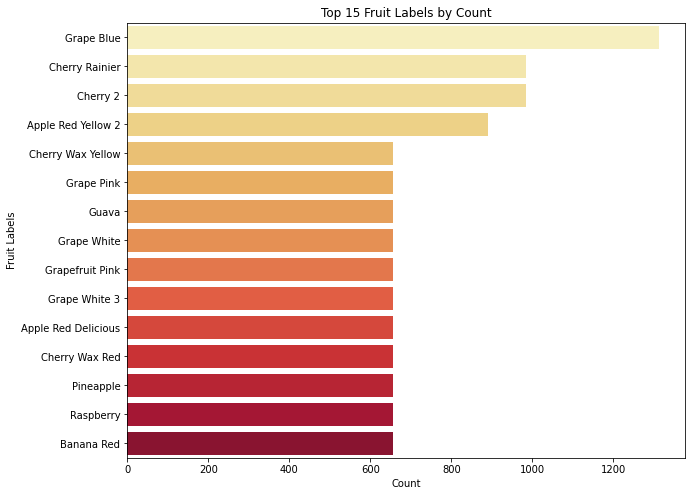

In [ ]:
# Combine the training and test label counts into a single dictionary
combined_label_counts = {
    label: training_label_counts.get(label, 0) + test_label_counts.get(label, 0)
    for label in set(list(training_label_counts.keys()) + list(test_label_counts.keys()))
}

# Create a DataFrame to hold the combined fruit counts
df_fruit_counts = pd.DataFrame({"Fruit Labels": list(combined_label_counts.keys()), "Count": list(combined_label_counts.values())})

# Sort the DataFrame by the counts in descending order
df_fruit_counts = df_fruit_counts.sort_values(by="Count", ascending=False)

# Select the top 15 fruit labels by count
top_15_fruits = df_fruit_counts.head(15)

# Plot the horizontal bar chart using Seaborn
plt.figure(figsize=(10, 8))
sns.barplot(x="Count", y="Fruit Labels", data=top_15_fruits, palette="YlOrRd")
plt.xlabel("Count")
plt.ylabel("Fruit Labels")
plt.title("Top 15 Fruit Labels by Count")
plt.show()

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 100
CHANNELS = 3
EPOCHS = 10

In [ ]:
# training dataset pipeline
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    training_subset,
    seed=42,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 19606 files belonging to 38 classes.


In [ ]:
#print training labels
tr_class_names = train_dataset.class_names
tr_class_names

['Apple Braeburn',
 'Apple Crimson Snow',
 'Apple Golden 1',
 'Apple Golden 2',
 'Apple Golden 3',
 'Apple Granny Smith',
 'Apple Pink Lady',
 'Apple Red 1',
 'Apple Red 2',
 'Apple Red 3',
 'Apple Red Delicious',
 'Apple Red Yellow 1',
 'Apple Red Yellow 2',
 'Banana',
 'Banana Lady Finger',
 'Banana Red',
 'Cherry 1',
 'Cherry 2',
 'Cherry Rainier',
 'Cherry Wax Black',
 'Cherry Wax Red',
 'Cherry Wax Yellow',
 'Grape Blue',
 'Grape Pink',
 'Grape White',
 'Grape White 2',
 'Grape White 3',
 'Grape White 4',
 'Grapefruit Pink',
 'Grapefruit White',
 'Guava',
 'Lychee',
 'Pineapple',
 'Pineapple Mini',
 'Rambutan',
 'Raspberry',
 'Redcurrant',
 'Salak']

**Data Exploration**

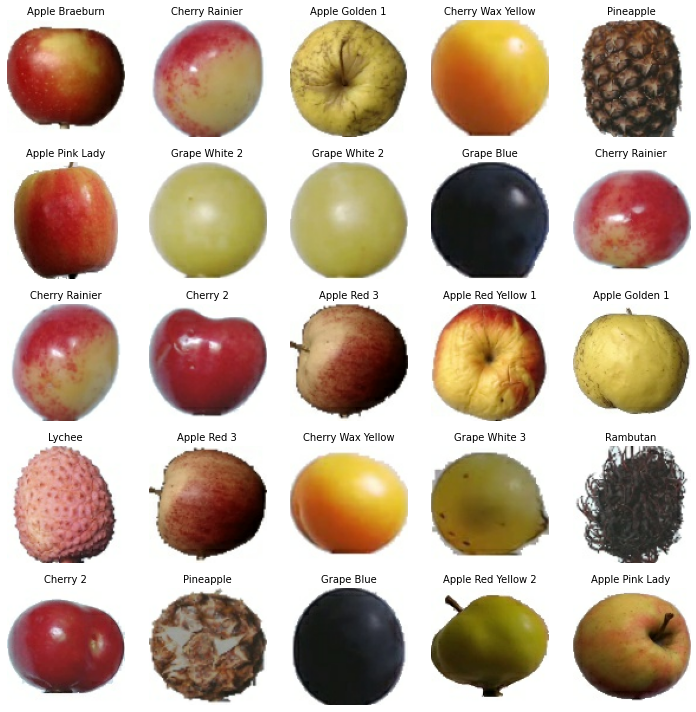

In [ ]:
#visualizing sample images from the dataset
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_dataset.take(9):
    for i in range(25):
        ax = plt.subplot(5,5, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(tr_class_names[labels_batch[i]], fontsize=10)
        plt.axis("off")

plt.tight_layout()
plt.show()


# 1.6 Preparing dataset

Next, let us split the data in the training folder into train and validation sets. The train set will be used to train the model, while the validation set will help evaluate the model performance and will also help to reduce overfitting, if any during training.

In [ ]:
# define a function to split the dataset
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.2, shuffle=True, shuffle_size=10000):
    assert (train_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=1234)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)

    return train_ds, val_ds

In [ ]:
train_ds, val_ds = get_dataset_partitions_tf(train_dataset)

In [ ]:
#print length of each set
print("Training dataset length",len(train_ds))
print("Validation dataset length",len(val_ds))

Training dataset length 490
Validation dataset length 122


In [ ]:
# Optimization for Training and Validation Datasets by caching and shuffling
train_ds = train_ds.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# resize and rescaling images to a specified size
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
# prefetching the training data to optimize pipeline
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

# 2. Building a multi-task or multi-output model in Keras

In [ ]:
# Defining the shape of the input data batch for CNN
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

# Number of outputs
n_classes = len(tr_class_names)
n_classes

38

# 2.1 Defining the CNN

Let us now define our CNN model with the Sequential API in Keras using the input_shape specified in the previous step.
This model will consist of multiple Conv2D and MaxPooling2D layers, followed by a Flatten layer, two Dense layers with dropout regularization, and a finally a Dense layer with softmax activation for multi-class classification
Also, the n_classes will represent the number of output classes.

In [ ]:
# CNN model
model = Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(32, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size =(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size =(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
# Review the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 100, 100, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 98, 98, 32)          896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 49, 49, 32)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 47, 47, 32)          9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 23, 23, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 21, 21, 64)         

### Choice of Optimizer
To build this fruit image classifier, we are using RMSprop instead of Adam due to its ability to handle sparse gradients. This can be an advantage as we have a multilabel task. This means we are dealing with sparse gradients due to multiple categories and sub categories.
Also our dataset has a varying complexities and different number of images in each class.
Thus, RMSprop can be used instead of adam to leverage its adaptive learning rate mechanism for a better fine-tuning to learning rates. This can possibly provide a better convergence and performance on our specific image classification task.

In [ ]:
# specifying the optimizer and model metrics
model.compile(
    optimizer='rmsprop',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# 2.2 Model Training

In [ ]:
# saving the model training history
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS
)

Epoch 1/10
490/490 [==============================] - 74s 144ms/step - loss: 1.0255 - accuracy: 0.6876 - val_loss: 0.1626 - val_accuracy: 0.9452
Epoch 2/10
490/490 [==============================] - 66s 134ms/step - loss: 0.1709 - accuracy: 0.9482 - val_loss: 0.0609 - val_accuracy: 0.9759
Epoch 3/10
490/490 [==============================] - 72s 147ms/step - loss: 0.0729 - accuracy: 0.9799 - val_loss: 0.0080 - val_accuracy: 0.9980
Epoch 4/10
490/490 [==============================] - 72s 147ms/step - loss: 0.0584 - accuracy: 0.9861 - val_loss: 4.3461e-04 - val_accuracy: 1.0000
Epoch 5/10
490/490 [==============================] - 73s 150ms/step - loss: 0.0420 - accuracy: 0.9909 - val_loss: 0.0992 - val_accuracy: 0.9759
Epoch 6/10
490/490 [==============================] - 74s 150ms/step - loss: 0.0308 - accuracy: 0.9944 - val_loss: 3.4364e-05 - val_accuracy: 1.0000
Epoch 7/10
490/490 [==============================] - 74s 151ms/step - loss: 0.0349 - accuracy: 0.9923 - val_loss: 7.1190e

# 2.3 Check for overfitting

If the deep learning CNN model gets too complex, it is likely to suffer from overfitting.
Overfitting indicates that the model begins to memorize the training data instead of learning general patterns.
A possible indicator of this is highly accurate model i.e. training and validation accuracies >90%. This also indicates that the model is biased to the images training data and a poor generalization on unseen images.

Let us plot the accuracy and loss curves to visualize the model training process.

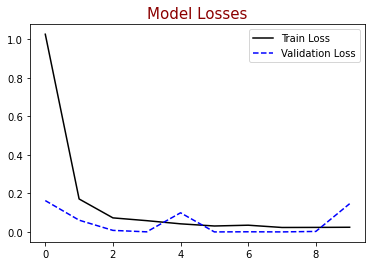

In [ ]:
#Plotting train & validation loss
plt.figure()
plt.plot(history.history["loss"],label = "Train Loss", color = "black")
plt.plot(history.history["val_loss"],label = "Validation Loss", color = "blue", linestyle="dashed")
plt.title("Model Losses", color = "darkred", size = 15)
plt.legend()
plt.show()

In [ ]:
loss, accuracy = model.evaluate(train_ds, verbose=1)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("model.h5")

122/122 [==============================] - 4s 31ms/step - loss: 0.1464 - accuracy: 0.9823
Validation: accuracy = 0.982326  ;  loss_v = 0.146412
Test: accuracy = 0.981876  ;  loss = 0.145834


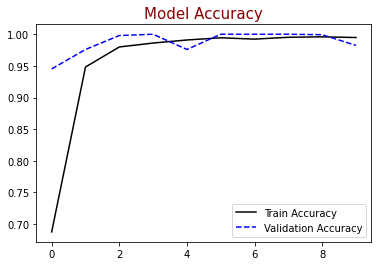

In [ ]:
#Plotting train & validation accuracy
plt.figure()
plt.plot(history .history["accuracy"],label = "Train Accuracy", color = "black")
plt.plot(history .history["val_accuracy"],label = "Validation Accuracy", color = "blue", linestyle="dashed")
plt.title("Model Accuracy", color = "darkred", size = 15)
plt.legend()
plt.show()

### Remarks:
* Since the training accuracy and validation accuracy follow a similar trend and both increase over the epochs, the model shows no signs of overfitting.
* Similarly, the training loss and validation loss decrease consistently, indicating a good fit between the model and the data.
* The model can be retrained for higher epochs with a different batch size for experimentation and evaluating a possible improvement in the model accuracy.

# 3. Predicting unseen images from test dataset

# 3.1 Creating a test data pipeline

In [ ]:
# test dataset pipeline
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
   test_subset,
    seed=42,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 6559 files belonging to 38 classes.


In [ ]:
#print training labels
ts_class_names = test_dataset.class_names
ts_class_names

['Apple Braeburn',
 'Apple Crimson Snow',
 'Apple Golden 1',
 'Apple Golden 2',
 'Apple Golden 3',
 'Apple Granny Smith',
 'Apple Pink Lady',
 'Apple Red 1',
 'Apple Red 2',
 'Apple Red 3',
 'Apple Red Delicious',
 'Apple Red Yellow 1',
 'Apple Red Yellow 2',
 'Banana',
 'Banana Lady Finger',
 'Banana Red',
 'Cherry 1',
 'Cherry 2',
 'Cherry Rainier',
 'Cherry Wax Black',
 'Cherry Wax Red',
 'Cherry Wax Yellow',
 'Grape Blue',
 'Grape Pink',
 'Grape White',
 'Grape White 2',
 'Grape White 3',
 'Grape White 4',
 'Grapefruit Pink',
 'Grapefruit White',
 'Guava',
 'Lychee',
 'Pineapple',
 'Pineapple Mini',
 'Rambutan',
 'Raspberry',
 'Redcurrant',
 'Salak']

# 3.2 Predicting a sample image

first image to predict
actual label: Cherry 2
1/1 [==============================] - 0s 124ms/step
predicted label: Cherry 2


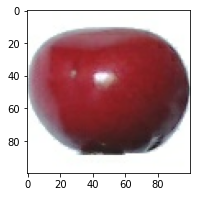

In [ ]:
# Fetching model predictions for sample image in test dataset
plt.figure(figsize=(3, 3))
for images_batch, labels_batch in test_dataset.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",ts_class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",tr_class_names[np.argmax(batch_prediction[0])])

# 3.3 Batch prediction on unseen images from test dataset

In [ ]:
# Defining prediction function for testing images
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = ts_class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

We will do a few set of predictions and visualize the results to have a better idea about how our model is performing.

### Prediction set 1


1/1 [==============================] - 0s 19ms/step


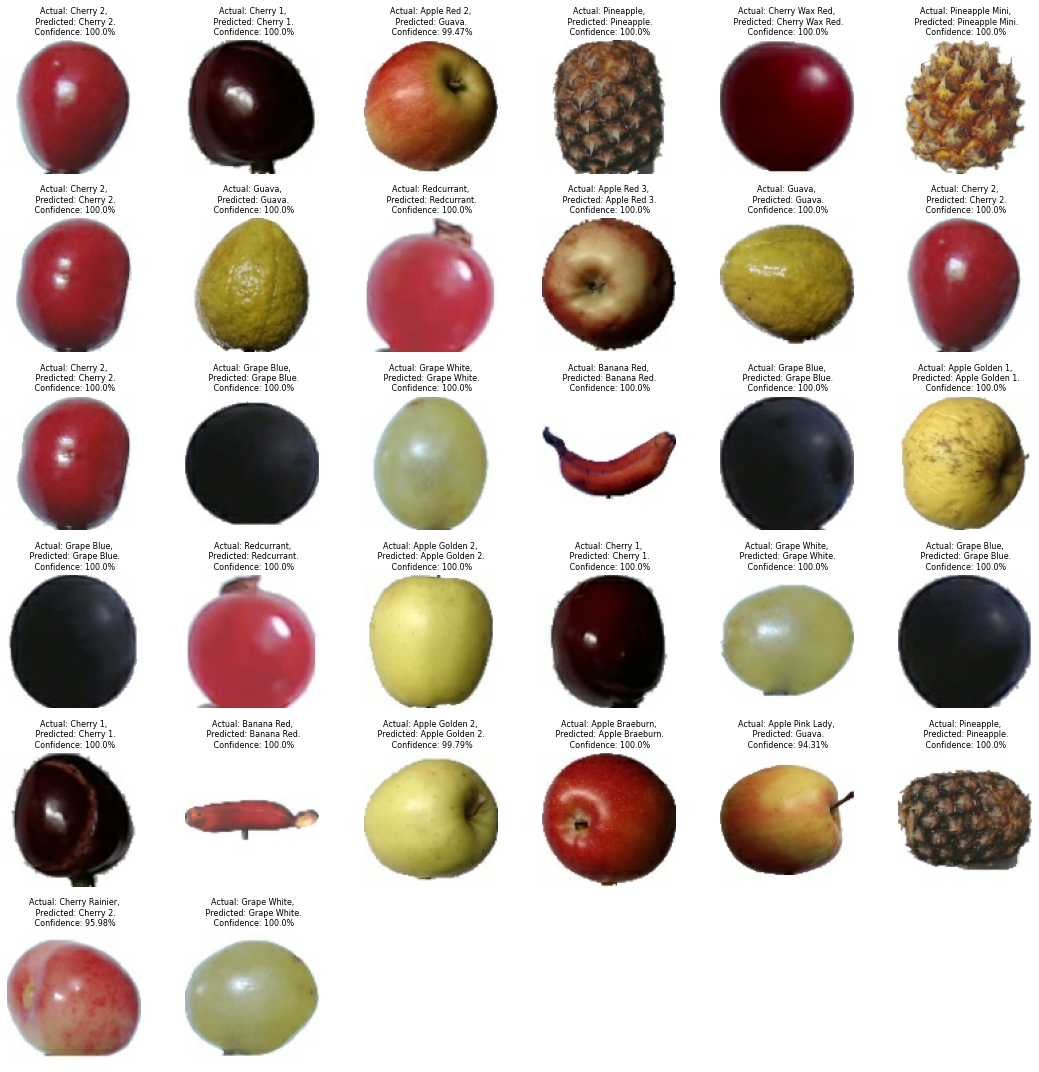

In [ ]:
plt.figure(figsize=(15, 15))

# Iterate over the batches and then the images to display their predictions
batch_size = 32
for images, labels in test_dataset.take(12):
    for i in range(batch_size):
        if i >= len(images):
            break

        ax = plt.subplot(6, 6, i + 1)
        image = tf.image.resize(images[i], (100, 100))
        plt.imshow(image.numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = ts_class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%", fontsize=8)
        plt.axis("off")

    # If there are more than batch size images, break out of the loop
    if i >= batch_size - 1:
        break

# Hide any empty subplots
for i in range(i + 1, batch_size):
    plt.subplot(6,6, i + 1)
    plt.axis("off")

plt.tight_layout()
plt.show()

### Prediction set 2


1/1 [==============================] - 0s 20ms/step


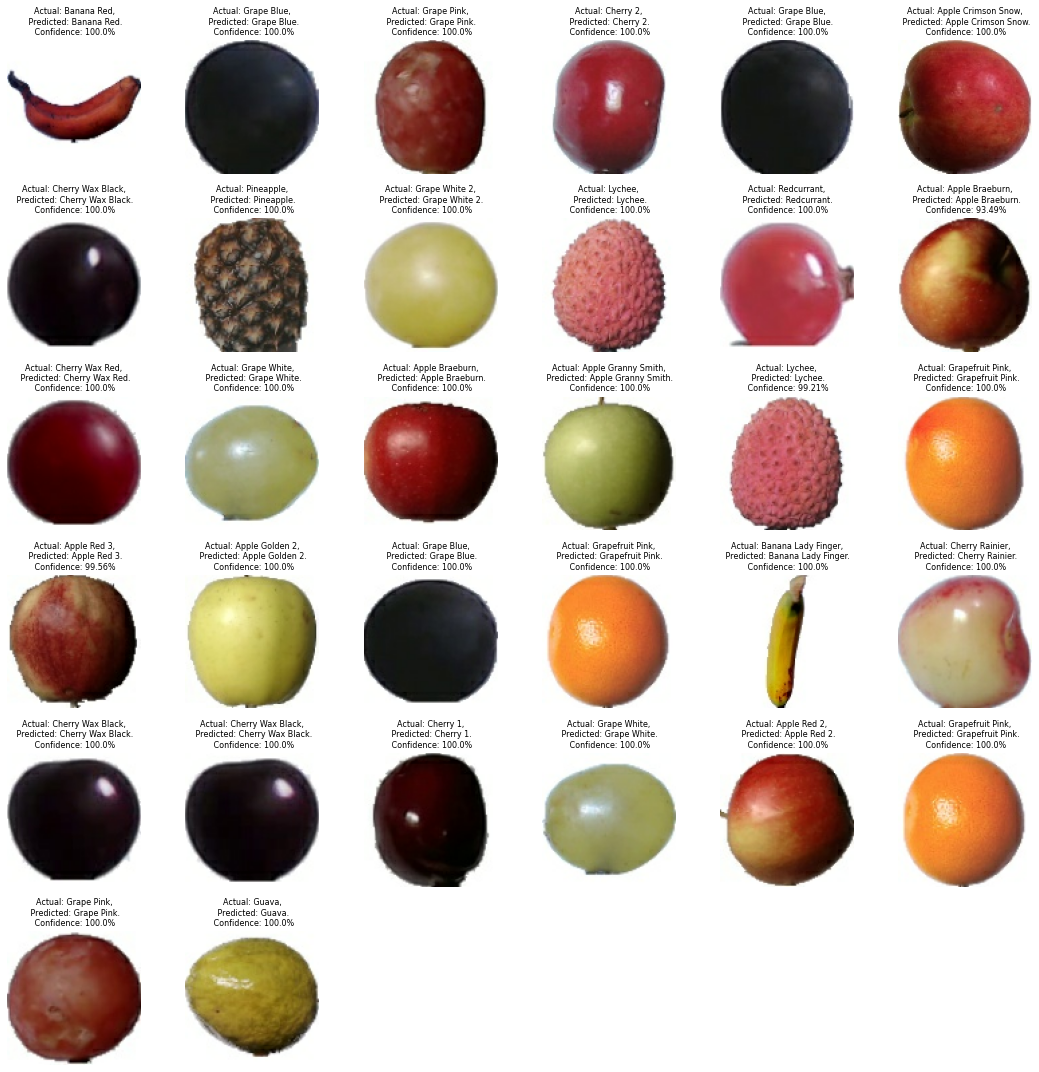

In [ ]:
plt.figure(figsize=(15, 15))

# Iterate over the batches and then the images to display their predictions
batch_size = 32
for images, labels in test_dataset.take(15):
    for i in range(batch_size):
        if i >= len(images):
            break

        ax = plt.subplot(6, 6, i + 1)
        image = tf.image.resize(images[i], (100, 100))
        plt.imshow(image.numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = ts_class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%", fontsize=8)
        plt.axis("off")

    # If there are more than batch size images, break out of the loop
    if i >= batch_size - 1:
        break

# Hide any empty subplots
for i in range(i + 1, batch_size):
    plt.subplot(6,6, i + 1)
    plt.axis("off")

plt.tight_layout()
plt.show()

# 4. Concluding Notes

* We created a fairly accurate fruit classifier in Keras with validation accuracy over 98%
* The model accurately predicted most of the considered fruit categories.
* The model seems to incorrectly label some of the fruit varieties with higher confidence. Since these varieties appear similar in colors and shapes, they can be challenging for the model to classify. This can be improved by -
    * Training the model with additional data using data augmentation in Keras
    * Experimenting with adding Batch normalization to the CNN layers to improve and stabilize the learning process
    * Adding more layers to the neural network
    * Adding L2 regularization
    * Experimenting with the dropout rate, learning rate

Apart from the above, the model does a really good job of classifying different fruits and their variants such as raspberry,pineapple, redcurrant, grapefruit, banana, etc.